Let's first load the necessary packages and libraries

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from Graph_Generation.simple_graph_generation import create_delaunay_graph
from Graph_Generation.target_graph import create_fully_connected_target_graph
from Graph_Generation.visibility import line_of_sight_visibility, two_hop_visibility
from Single_Agent.repeated_topk import RepeatedTopK

Let's generate the graph (a 2D denaunay graph)


At the moment we have the following graph features


Node Level: 

- "type": "source", "target_unreached", "target_reached", "intermediate" 

- "visible_edges": a map from each node to the visible edges 

- 'pos' : a 2D tuple of the nodes' position

Edge Level: 

- "distance": Euclidian distance of the edge 

- "observed_edge" : boolean of whether or not the edge was observed 
    
- "num_used" : an edge value function 

In [2]:
num_nodes = 64
env_graph = create_delaunay_graph(64, target_ratio = 4/64, seed = 68)
_ = two_hop_visibility(env_graph, num_extended_nodes=4)
target_graph = create_fully_connected_target_graph(env_graph)

Let's first visualize the environment graph

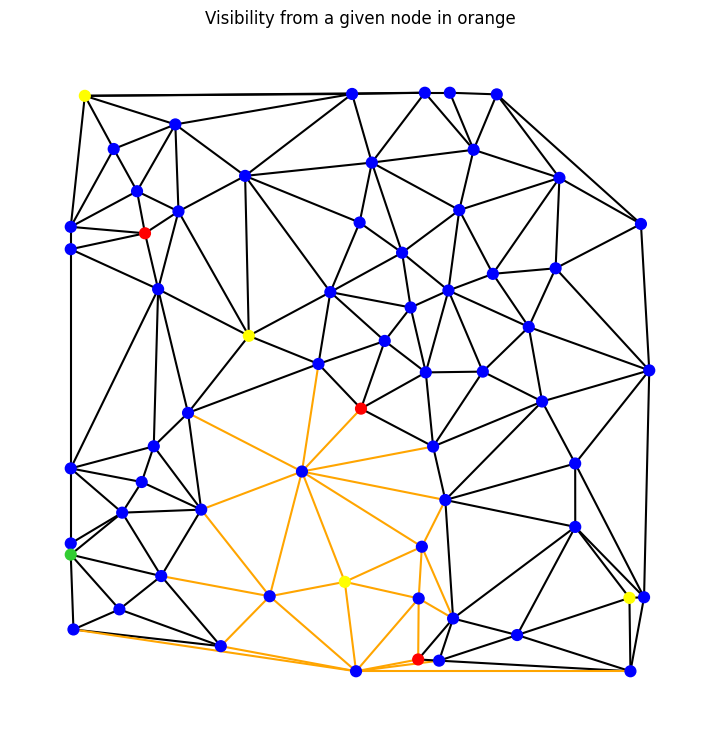

In [3]:
extended_nodes = [node for node in env_graph.nodes() 
                  if env_graph.nodes[node].get('has_extended_visibility', True)]
non_extended_nodes = [node for node in env_graph.nodes() 
                  if env_graph.nodes[node].get('has_extended_visibility', False)]

source_node = extended_nodes[0] if extended_nodes else non_extended_nodes[0]
visible_edges = env_graph.nodes[source_node]['visible_edges']

# Get positions from node attributes
pos = nx.get_node_attributes(env_graph, 'pos')

# Create a list of colors based on node attributes
color_map = []
for node, data in env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

edge_color = []
for u, v, data in env_graph.edges(data=True):
    edge_tuple = tuple(sorted((u, v)))
    if edge_tuple in visible_edges:
        # Style for visible edges: orange
        edge_color.append('orange')
    else:
        # Style for invisible edges: black
        edge_color.append('black')

# Draw the graph with updated styles
plt.figure(figsize=(7, 7))
nx.draw(
    env_graph,
    pos=pos,
    node_color=color_map, 
    with_labels=False,
    node_size=60,
    width=1.5,
    edge_color=edge_color
)

plt.title("Visibility from a given node in orange")
plt.show()

Let's also visulize the target graph and the 'num_used' weights

The target graph is a simpler graph made of only the target nodes. The edges are generated by connecting the 4 closest neighbors.

The target graph feature are

Node Level: 

- "type": "source", "target_unreached", "target_reached", "intermediate" 

- 'pos' : a 2D tuple of the nodes' position


Edge Level: 

- 'distance': Shortest Path length between the two target nodes

- 'diverse_paths' : A list containing 3 of the shortest diverse paths between the two targets 

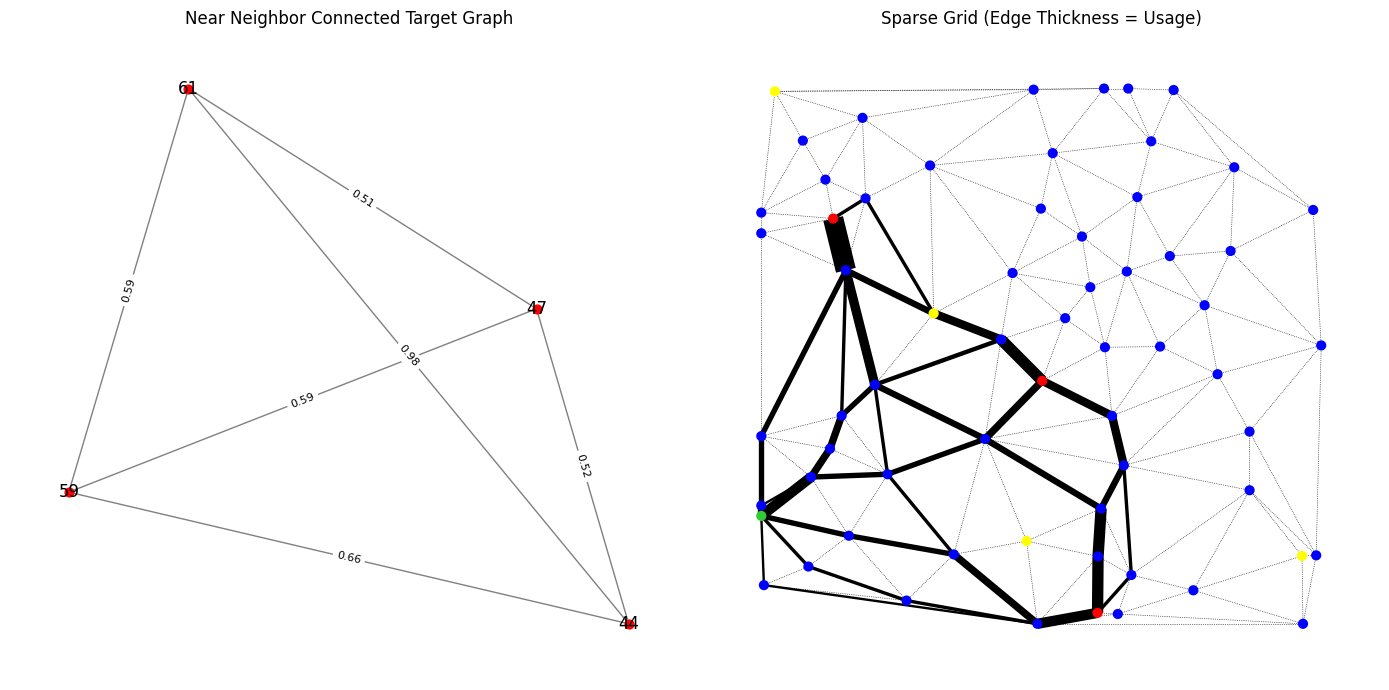

In [4]:
# --- 1. Prepare for Plotting ---

# Get positions from node attributes
pos = nx.get_node_attributes(env_graph, 'pos')

extended_nodes = [node for node in env_graph.nodes() 
                  if env_graph.nodes[node].get('has_extended_visibility', True)]

color_map = []
for node, data in env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")   
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

edge_labels = {}
for u, v, data in target_graph.edges(data=True):
    distance = data['distance']
    edge_labels[(u, v)] = f"{distance:.2f}"

# --- 2. Create Dynamic Edge Styles for the Sparse Grid ---

edge_widths = []
edge_styles = []
for u, v, data in env_graph.edges(data=True):
    num_used = data.get('num_used', 0)
    if num_used > 0:
        # Style for used edges: solid and thicker based on usage count
        edge_styles.append('solid')
        edge_widths.append(1.0 + 5.0 * num_used)  # Scaled for visibility
    else:
        # Style for unused edges: dotted and thin
        edge_styles.append('dotted')
        edge_widths.append(0.5)

# --- 3. Create the Side-by-Side Plot (in the new order) ---

# Create a figure and a set of subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# --- Plot 1: Fully Connected Target Graph (NOW on the left axis) ---
axes[0].set_title("Near Neighbor Connected Target Graph")
nx.draw(
    target_graph,
    pos=pos,
    ax=axes[0],  # Draw on the left subplot
    node_color="red",
    with_labels=True,
    node_size=40,
    width=1.0,
    edge_color='grey'
)

nx.draw_networkx_edge_labels(
    target_graph, 
    pos=pos,
    ax =axes[0],
    edge_labels=edge_labels,
    font_size=8
)

# --- Plot 2: Original Sparse Grid with Usage (NOW on the right axis) ---
axes[1].set_title("Sparse Grid (Edge Thickness = Usage)")
nx.draw(
    env_graph,
    pos=pos,
    ax=axes[1],  # Draw on the right subplot
    node_color=color_map,
    with_labels=False,
    node_size=40,
    width=edge_widths,  # Use the dynamic widths
    style=edge_styles   # Use the dynamic styles
)

plt.tight_layout()
plt.show()

Let's now create a modified visibility infused distance measure using the following equation

\begin{equation}
    w'(s_1, s_2) = \mathrm{distance}(s_1, s_2) - \lambda \cdot R_{vis}(s_2)

\end{equation}

In [5]:
path_generator = RepeatedTopK(reward_ratio = 0.0, env_graph=env_graph, target_graph=target_graph)

trajectory = path_generator.find_best_path()

TSP Cycle: [44, 59, 61, 47]
Processing section from 59 to 61
Processing section from 61 to 47
Processing section from 47 to 44
Original Hamiltonian Path Reward: -1.626024562279893
Best Path Reward: -1.626024562279893


c:\Users\jongs\OneDrive\UIUC Folder\LEADCAT\Uncertain Edge TSP\Single_Agent\lin_kernighan_tsp.py:218: RuntimeWarning: invalid value encountered in scalar subtract
  hamiltonian_path_distance


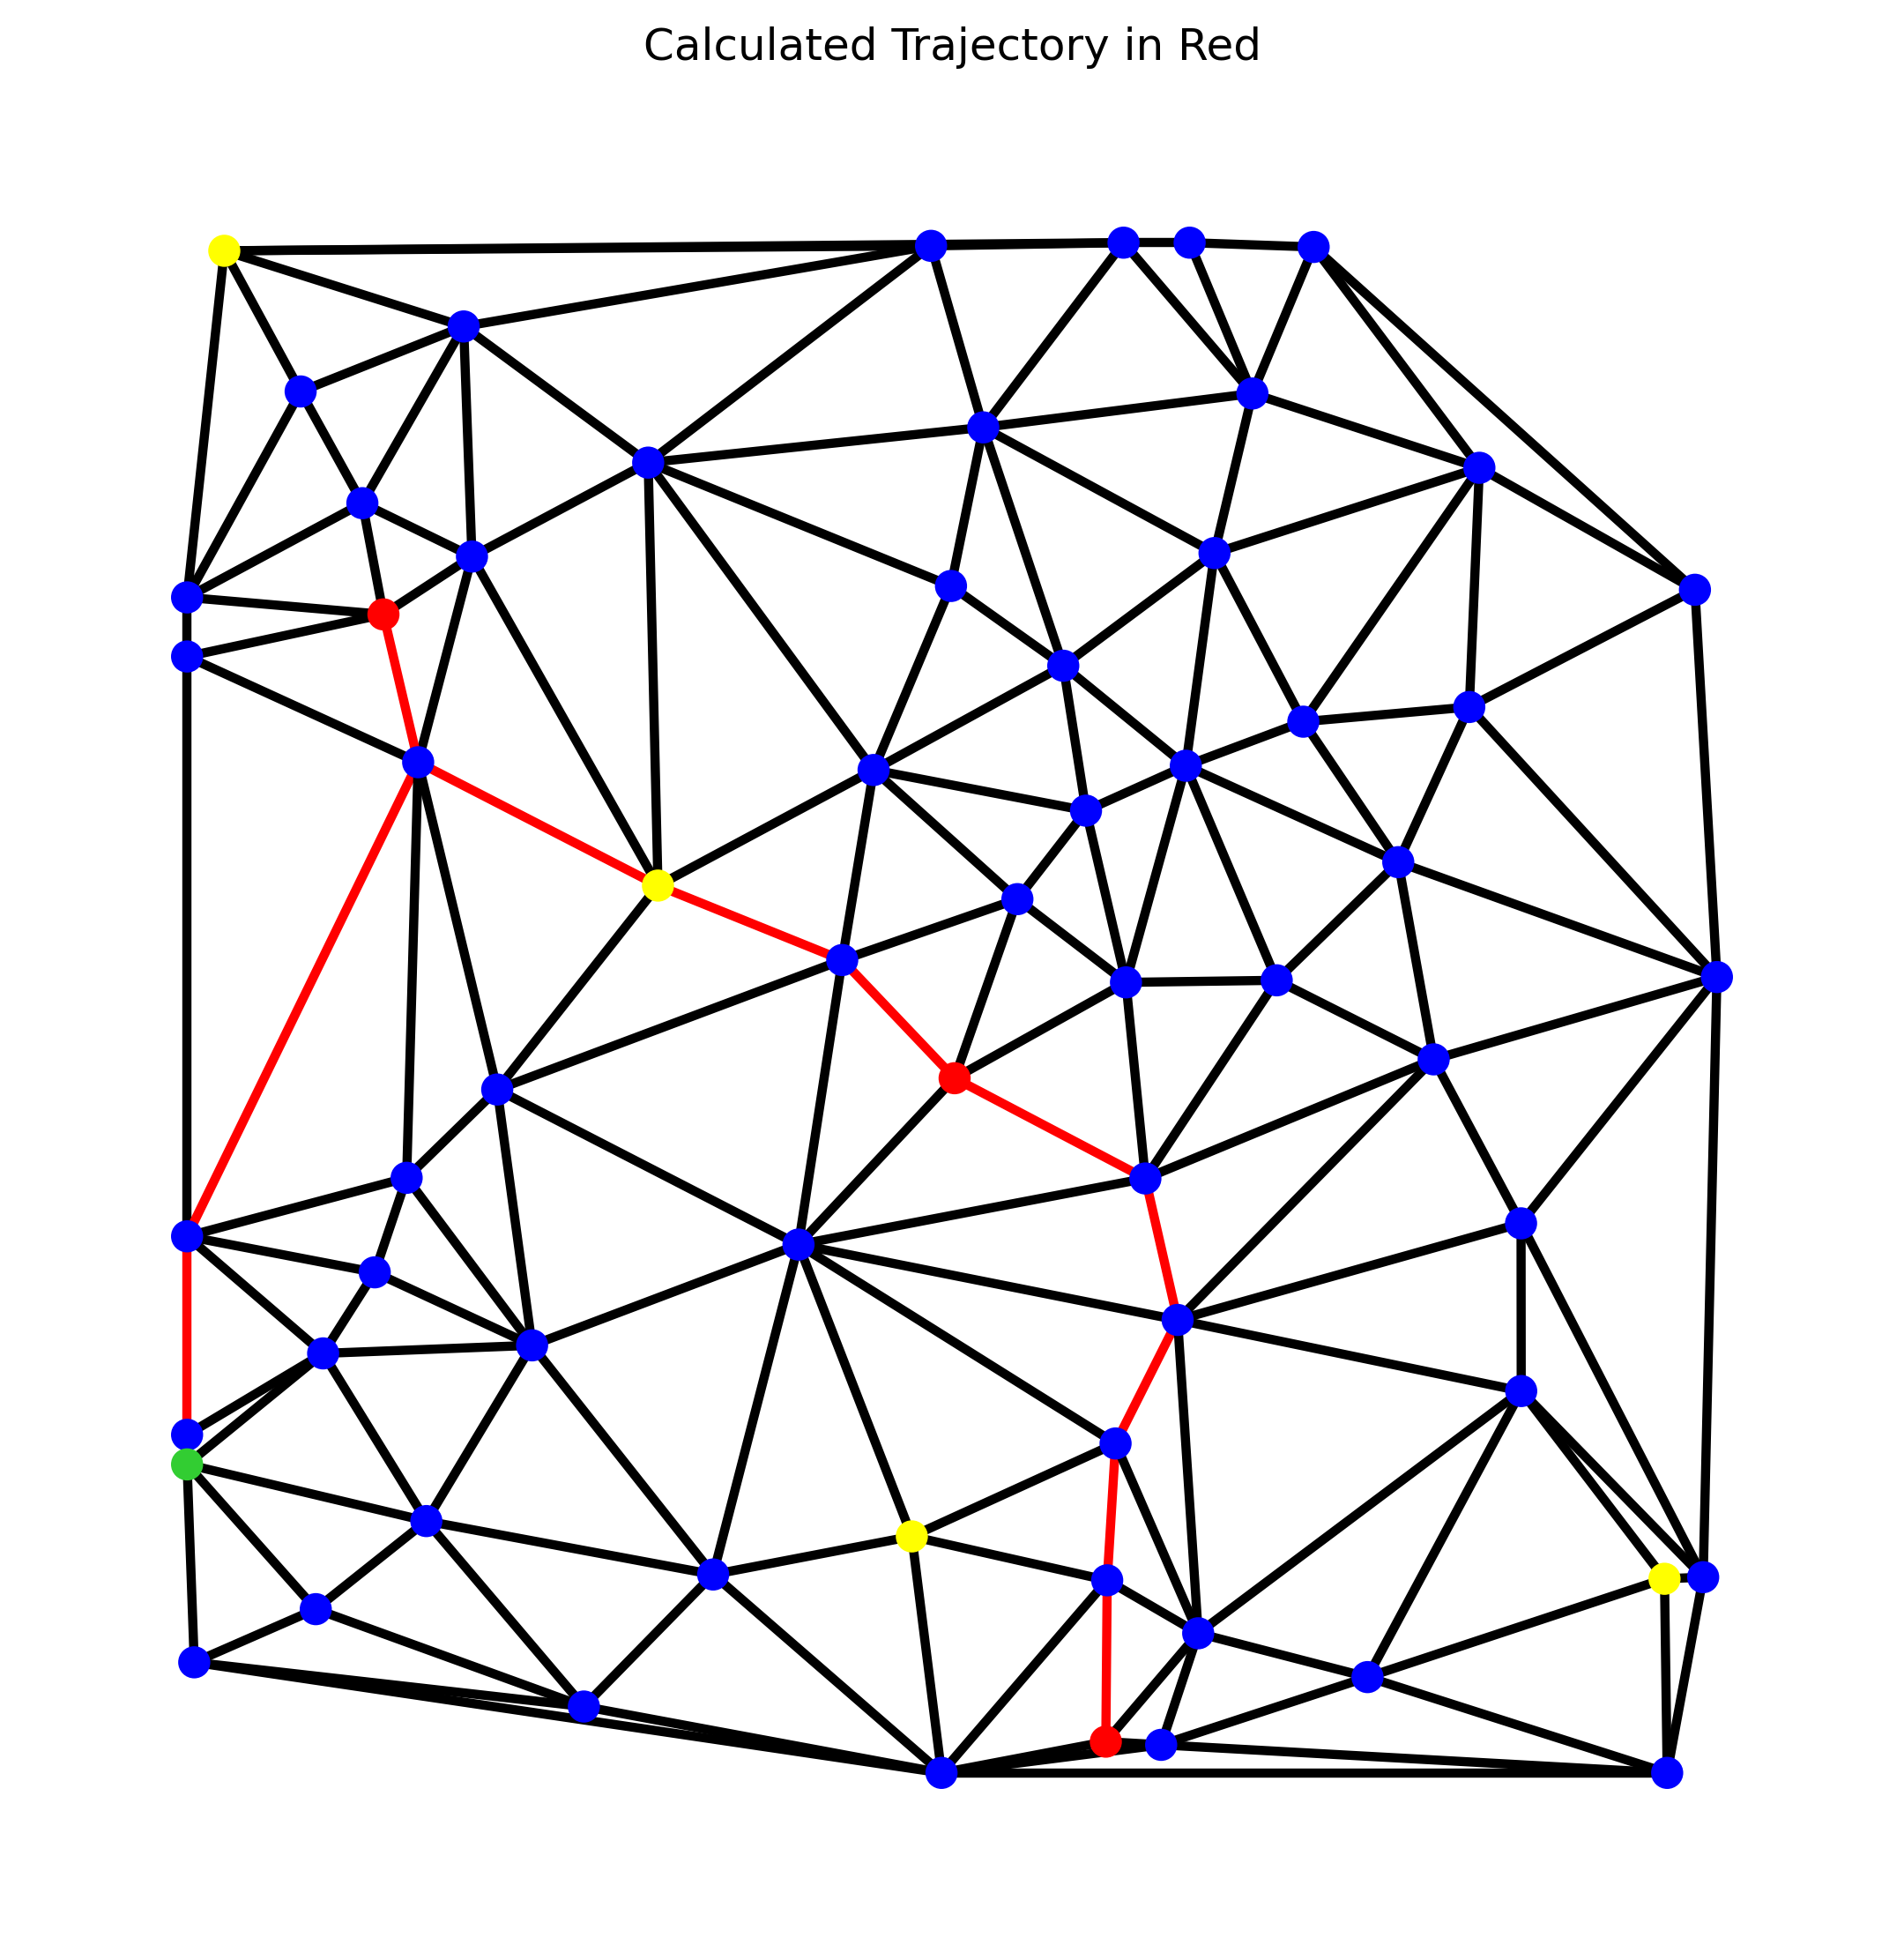

In [6]:
# Convert trajectory nodes to edges
trajectory_edges = {tuple(sorted((trajectory[i], trajectory[i+1]))) 
                   for i in range(len(trajectory) - 1)}

# Get positions from node attributes
pos = nx.get_node_attributes(env_graph, 'pos')

extended_nodes = [node for node in env_graph.nodes() 
                  if env_graph.nodes[node].get('has_extended_visibility', True)]

color_map = []
for node, data in env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")   
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

edge_color = []
for u, v, data in env_graph.edges(data=True):
    edge_tuple = tuple(sorted((u, v)))
    if edge_tuple in trajectory_edges:
        edge_color.append('red')
    else:
        # Style for invisible edges: black
        edge_color.append('black')

# Draw the graph with updated styles
plt.figure(figsize=(7, 7), dpi=300)
nx.draw(
    env_graph,
    pos=pos,
    node_color=color_map,
    with_labels=False, 
    node_size=60,
    width=2.5,
    edge_color=edge_color,
)

plt.title("Calculated Trajectory in Red")  # Changed to Red since edges are red
plt.show()